In [1]:
import os
os.environ['RESULTS_VERS'] = 'l33'
from astropy.table import Table
from astropy.io import ascii
import pandas
import astropy.units as u
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import scipy.stats as stats
from scipy.interpolate import InterpolatedUnivariateSpline, UnivariateSpline
import apogee.tools.read as apread
plt.style.use('nature') # this is one of my plotting styles so youll need to comment out if you're running the NB!

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Lets see if we can do something about the bug with the Battistini and Bitsch model application to the simulation...

Loading in the data first, scraped from the BB paper:

In [2]:
BBmodel = ascii.read("../sav/Combineddata.csv",data_start=2)
BBmodel.rename_column('\ufeffFe_H', 'Fe_H')

Comp = Table(BBmodel)
Comp

Fe_H,Fe3O4_top,FeS_top,Mg2SiO4_top,Fe2_O3_top,MgSiO3_top,Fe3O4_bottom,FeS_bottom,Mg2SiO4_bottom,Fe2O3_bottom,MgSiO3_bottom,H20
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-0.3,0.101077057,0.196159024,0.324027877,0.104355746,0.301092896,0.054518015,0.099679306,0.164195435,0.05451802,0.152905112,0.48193737
-0.2,0.108711491,0.192318049,0.341498376,0.112006019,0.27756395,0.060644218,0.105810224,0.186455386,0.06226184,0.152584418,0.438068289
-0.1,0.114706581,0.188492912,0.358968876,0.119640453,0.255706027,0.06838804,0.108715337,0.205484814,0.06838804,0.147425014,0.405484814
0.0,0.12071751,0.187930625,0.35514374,0.122356854,0.25514374,0.076131862,0.118067346,0.222906055,0.07613186,0.16000283,0.35032541
0.1,0.120155223,0.187368338,0.379171616,0.123433911,0.236548666,0.080649877,0.127424071,0.259682135,0.08226278,0.161295039,0.287096774
0.2,0.121248119,0.188429556,0.401575988,0.124510969,0.219608775,0.088393699,0.138393699,0.302909828,0.0883937,0.162582532,0.214195435
0.3,0.11575196,0.19280114,0.410849766,0.119046488,0.222309337,0.088068289,0.150976231,0.331621392,0.09129881,0.178395586,0.152584418
0.4,0.116844856,0.188976004,0.451271086,0.120123545,0.184057971,0.097425014,0.16516695,0.403876627,0.10065082,0.16032824,0.066779853


OK - these are the data from the appropriate figure. We only really care about the $\mathrm{[Fe/H]}$ vs water mass fraction

Now we'll do the polynomial fit...

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
            c0                  c1                  c2                  c3        
    ------------------ ------------------- ------------------- -------------------
    0.3480026126904762 -0.5659026289285716 -0.3847110642857163 0.12633408333333815


(-0.1, 1.1)

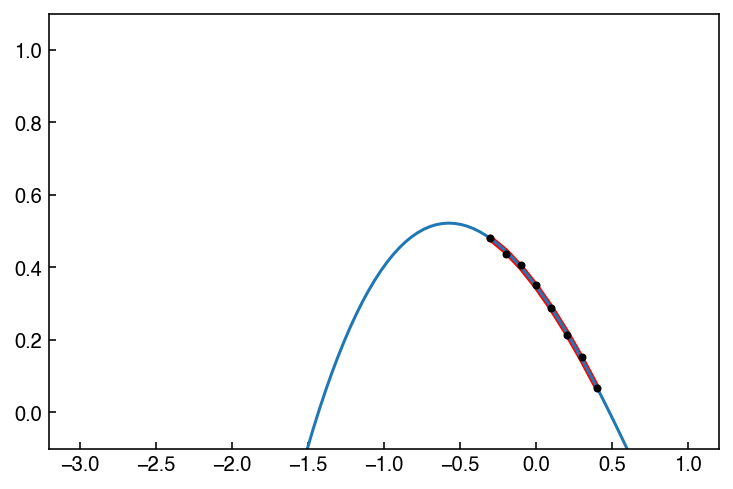

In [3]:
# Now interpolate between points

model_poly = models.Polynomial1D(degree=3)
fitter_poly = fitting.LinearLSQFitter()
best_fit_poly = fitter_poly(model_poly, BBmodel['Fe_H'],BBmodel['H20'])

print(best_fit_poly)

plt.errorbar(BBmodel['Fe_H'],BBmodel['H20'], fmt='k.')
plt.plot(BBmodel['Fe_H'],best_fit_poly(BBmodel['Fe_H']),color='r', linewidth=3)

newxs = np.linspace(-3,1.,100)

plt.plot(newxs, best_fit_poly(newxs))
plt.ylim(-0.1,1.1)

This doesnt look ideal at the low $\mathrm{[Fe/H]}$ end, so we can try some other options here... what about a spline?

(-0.1, 1.1)

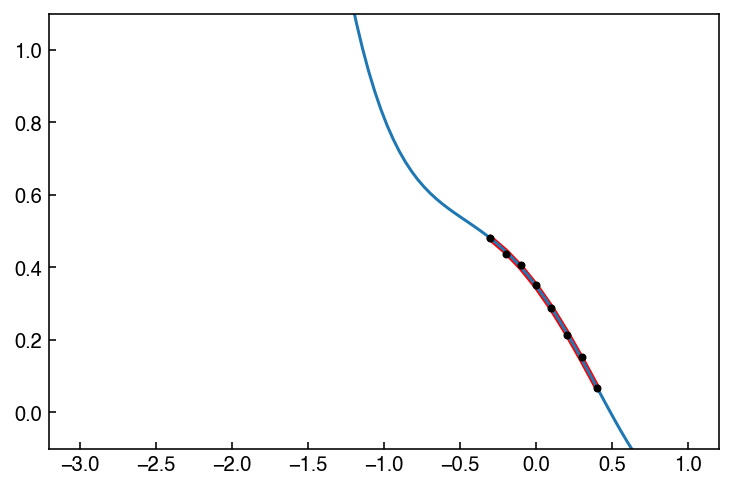

In [4]:
s = UnivariateSpline(BBmodel['Fe_H'],BBmodel['H20'], k=4)


plt.errorbar(BBmodel['Fe_H'],BBmodel['H20'], fmt='k.')
plt.plot(BBmodel['Fe_H'],s(BBmodel['Fe_H']),color='r', linewidth=3)

newxs = np.linspace(-3,1.,100)

plt.plot(newxs, s(newxs))
plt.ylim(-0.1,1.1)

Again, not ideal since the mass fraction can get to above 1 (and below 0....). What actually happens in the data we have for stars?

In [5]:
#we'll grab the APOGEE data using jobovy's apogee code (this requires some set-up, ask Ted for details...)
allstar = apread.allStar(main=True, exclude_star_bad=True, exclude_star_warn=True) 

/Users/tedmackereth/anaconda3/lib/python3.7/site-packages/apogee-1.-py3.7.egg/apogee/tools/read.py:303: RuntimeWarning: Extinction-corrected J,H,K not added because esutil is not installed
  warnings.warn("Extinction-corrected J,H,K not added because esutil is not installed",RuntimeWarning)


in the BB paper, they looked at C/O abundances in GALAH, to see what happens with O as the $\mathrm{[Fe/H]}$ increases (more O is locked into CO and CO2 at increasing Fe). We can use this idea to figure out what might be the best course of action at the low Fe end as well?

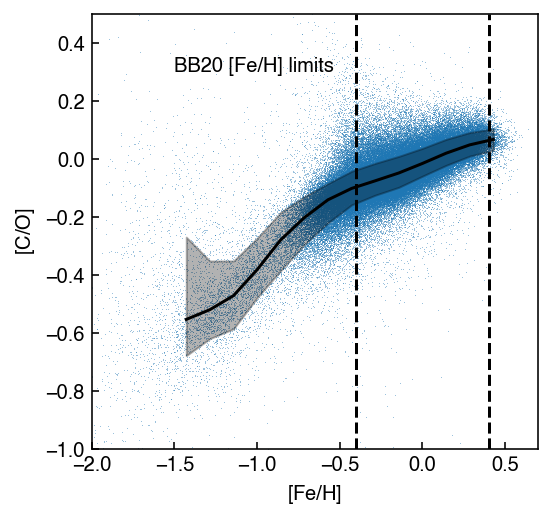

In [6]:
fig = plt.figure()
fig.set_size_inches(4,4)

#we'll clean up the APOGEE data a bit to only look at stars where the abundances are probably good (red giants)
bad = (allstar['LOGG_ERR'] < 0.1) & (allstar['LOGG'] < 4)&  (allstar['LOGG'] > 1) & (allstar['C_FE'] != -9999.9902) & (allstar['O_FE'] != -9999.9902)



plt.scatter(allstar['FE_H'][bad], allstar['C_FE'][bad]-allstar['O_FE'][bad], s=0.1, lw=0., alpha=0.8, rasterized=True)
plt.xlim(-2.,0.7)
plt.ylim(-1,0.5)

def running_percentile(x, y, bins):
    '''quick function to get the running median/percentiles'''
    bin_inds = np.digitize(x, bins)
    values = np.ones((len(bins),3))*np.nan
    for i in np.unique(bin_inds):
        if i == 0 or i == 15:
            continue
        in_bin = bin_inds == i
        if sum(in_bin) < 10:
            continue
        values[i] = np.percentile(y[in_bin], [16,50,84])
    bin_centers = (bins[1:]+bins[:-1])/2.
    return values, bin_centers
        
bins = np.linspace(-1.5,0.5,15)
medians, bin_centers = running_percentile(allstar['FE_H'][bad], allstar['C_FE'][bad]-allstar['O_FE'][bad], bins)  

plt.plot(bins-((bins[1]-bins[0])/2.), medians[:,1], c='Black')
plt.fill_between(bins-((bins[1]-bins[0])/2.), medians[:,0], medians[:,2], color='Black', alpha=0.3)

plt.axvline(-0.4, color='Black', linestyle='dashed')
plt.axvline(0.4, color='Black', linestyle='dashed')
plt.text(-1.5,0.3, 'BB20 [Fe/H] limits')

plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$\mathrm{[C/O]}$')

plt.savefig('../plots/CO_FEH_APOGEEDR16.pdf')

the APOGEE behaviour matches GALAH quite well in the BB limits, which is reassuring, but the trend changes quite significantly at low $\mathrm{[Fe/H]}$. Since the C/O drops right off, we might assume that the Oxygen available in forming the ISO's at low metallicities is much higher? 

Since the accreted dwarfs probably dominate in terms of mass at this metallicity regime, maybe this means that the ISO's accreted in dwarfs would be genuinely disentangle-able from the MW ones...

Just to illustrate that there is a lot of accreted debris down there at low metallicity - you can see that this stands out in the Tinsley diagram as a larger scatter in $\mathrm{[Mg/Fe]}$ (alpha elements) at low $\mathrm{[Fe/H]}$.

(-0.2, 0.5)

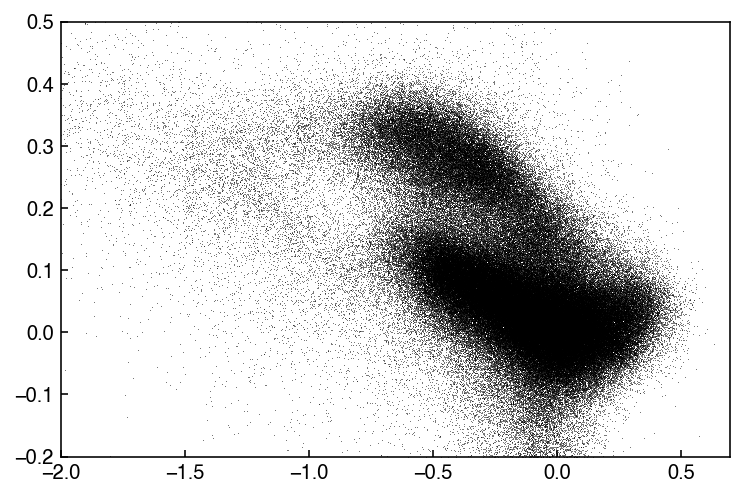

In [7]:
plt.scatter(allstar['FE_H'], allstar['MG_FE'], s=0.1, lw=0., color='Black')
plt.xlim(-2,0.7)
plt.ylim(-0.2,0.5)

In that case, maybe the polynomial is ok. I think the best we can do is to just set the function to be the upper and lower limit:

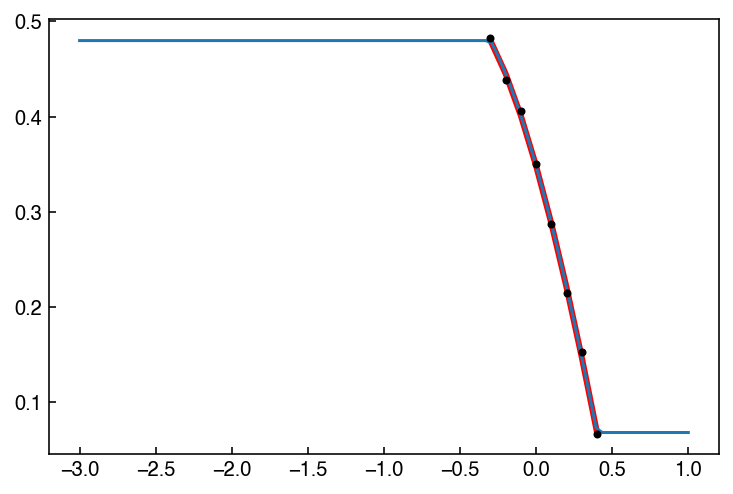

In [8]:
# Now interpolate between points

def piecewise_poly(x):
    '''this function allows us to set the extrapolation to the limits of the data in x'''
    model_poly = models.Polynomial1D(degree=3)
    fitter_poly = fitting.LinearLSQFitter()
    best_fit_poly = fitter_poly(model_poly, BBmodel['Fe_H'],BBmodel['H20'])
    minx, maxx = np.min(BBmodel['Fe_H']), np.max(BBmodel['Fe_H'])
    minxy = best_fit_poly(minx)
    maxxy = best_fit_poly(maxx)
    if not hasattr(x, '__iter__'):
        if x < minx:
            return minxy
        elif x > maxx:
            return maxxy
        else:
            return best_fit_poly(x)
    else:
        out = np.zeros(len(x))
        out[x < minx] = minxy
        out[x > maxx] = maxxy
        out[(x >= minx) & (x <= maxx)] = best_fit_poly(x[(x >= minx) & (x <= maxx)])
        return out

plt.errorbar(BBmodel['Fe_H'],BBmodel['H20'], fmt='k.')
plt.plot(BBmodel['Fe_H'],piecewise_poly(BBmodel['Fe_H']),color='r', linewidth=3)

newxs = np.linspace(-3,1.,100)

plt.plot(newxs, piecewise_poly(newxs))

In [9]:
files = ['GalaxyA_FOF507.dat', 'EAGLE_MW_L0025N0376_REFERENCE_ApogeeRun_30kpc_working.dat', 'GalaxyC_FOF526.dat']

sims = [ascii.read('../sav/%s' % file) for file in files]

/Users/tedmackereth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


Text(0, 0.5, '$\\mathrm{[Mg/Fe]}$')

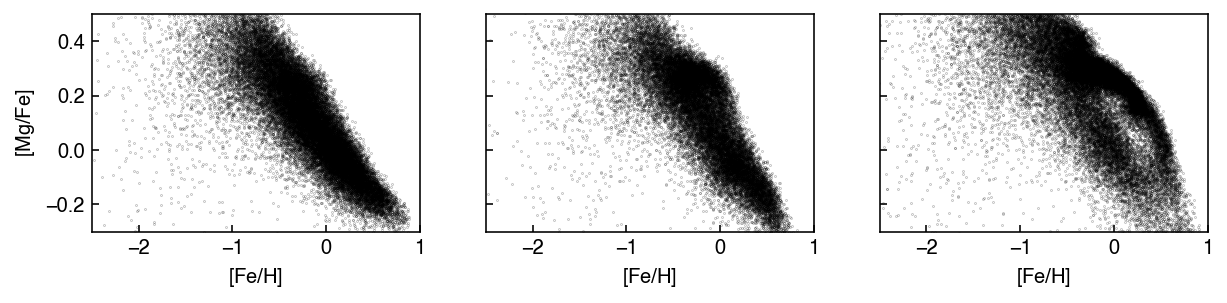

In [10]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)
fig.set_size_inches(10,2)
for i in range(len(sims)):
    ax[i].scatter(sims[i]['fe_h'], sims[i]['mg_h']-sims[i]['fe_h'], s=0.01, color='Black')
    ax[i].set_xlabel(r'$\mathrm{[Fe/H]}$')

plt.xlim(-2.5,1.)
plt.ylim(-0.3,0.5)
ax[0].set_ylabel(r'$\mathrm{[Mg/Fe]}$')


Text(0, 0.5, '$z\\ \\mathrm{[kpc]}$')

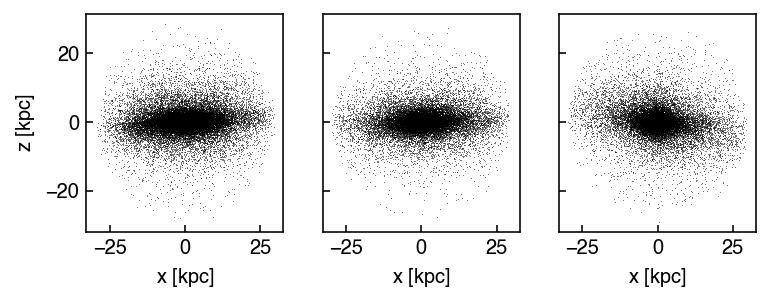

In [11]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)
fig.set_size_inches(6,2)
for i in range(len(sims)):
    ax[i].scatter(sims[i]['x_g'], sims[i]['z_g'], s=0.1, lw=0., color='Black')
    ax[i].set_xlabel(r'$x\ \mathrm{[kpc]}$')
ax[0].set_ylabel(r'$z\ \mathrm{[kpc]}$')


lets re-make Chris' plot with the fixed limits (note I also do a thing to 'spread out' the probability density where we extrapolate... not sure if this is useful though...)

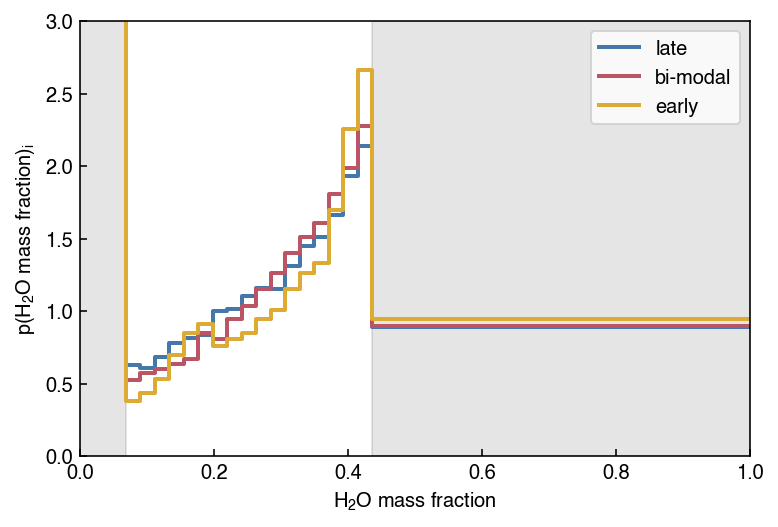

In [12]:
colors = ['#4477AA', '#BB5566', '#DDAA33']
labels = ['late', 'bi-modal', 'early']

frac_water_rich = []
mean_age = []
for i in range(len(sims)):
    water_mass_frac = piecewise_poly(sims[i]['fe_h'])
    bins = np.linspace(np.min(water_mass_frac),np.max(water_mass_frac),20)
    hist, bins = np.histogram(water_mass_frac, bins=bins, density=True)
    old_end = np.copy(bins[-2])
    #figure out the correction to get the final bin probability density right...
    end_correct = (bins[1]-bins[0])/(1-old_end)
    bins[-2] = 1.
    hist[-1] *= end_correct
    plt.step(bins[:-1], hist, color=colors[i], lw=2., label=labels[i])
    frac_water_rich.append(sum(water_mass_frac > 0.4)/len(water_mass_frac))
    mean_age.append(np.mean(sims[i]['age']))
    
plt.xlim(0.,1.)
plt.ylim(0.,3)
plt.legend()
plt.xlabel(r'$\mathrm{H_2O\ mass\ fraction}$')
plt.ylabel(r'$p(\mathrm{H_2O\ mass\ fraction})_i$')

#mark out the regions where we extrapolate
plt.gca().axvspan(bins[-3], 1., alpha=0.1, color='Black')
plt.gca().axvspan(0, bins[0], alpha=0.1, color='Black')

Text(0, 0.5, '$p(\\mathrm{H_2O\\ mass\\ fraction})_i$')

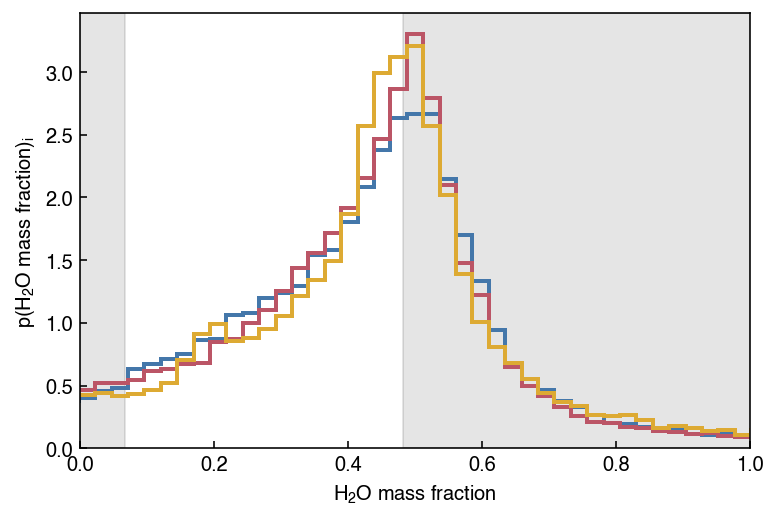

In [13]:
#just for fun, how does it look with the spline?
frac_water_rich = []
mean_age = []
for i in range(len(sims)):
    water_mass_frac = s(sims[i]['fe_h'])
    bins = np.linspace(-0.1,1.1,50)
    plt.hist(water_mass_frac, histtype='step', density=True, bins=bins, lw=2., color=colors[i])
    frac_water_rich.append(sum(water_mass_frac > 0.4)/len(water_mass_frac))
    mean_age.append(np.mean(sims[i]['age']))
    
#mark out the regions where we extrapolate
plt.gca().axvspan(np.max(BBmodel['H20']), 1., alpha=0.1, color='Black')
plt.gca().axvspan(0, np.min(BBmodel['H20']), alpha=0.1, color='Black')

plt.xlim(0.,1.)

plt.xlabel(r'$\mathrm{H_2O\ mass\ fraction}$')
plt.ylabel(r'$p(\mathrm{H_2O\ mass\ fraction})_i$')

If the behaviour is anything like the spline fit, then (i.e. the water mass fraction goes much higher at low Fe) then we actually still see a peak at ~0.5 for the EAGLE galaxies...

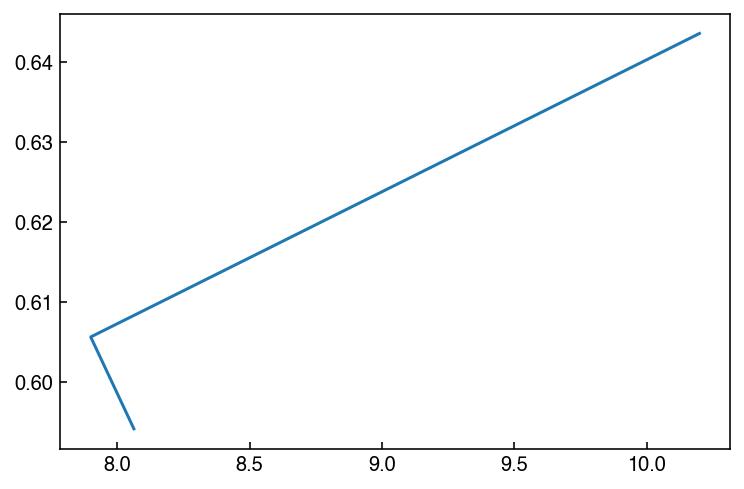

In [14]:
plt.plot(mean_age, frac_water_rich)

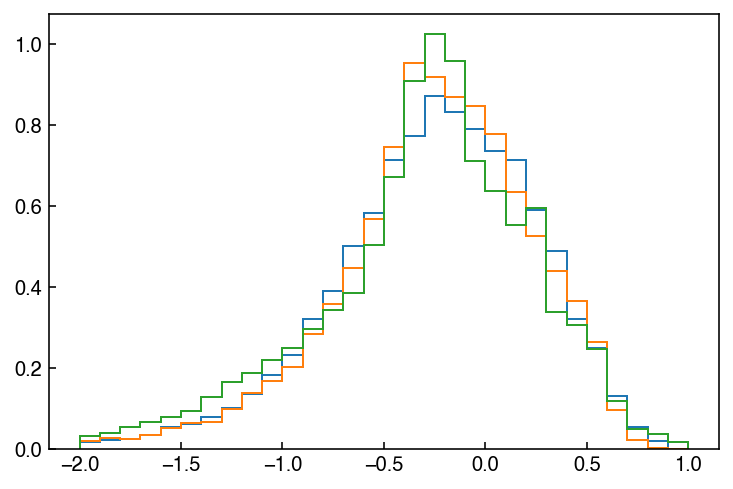

In [15]:
#plot the MDF of each galaxy...
for i in range(len(sims)):
    plt.hist(sims[i]['fe_h'], range=[-2,1.], histtype='step', density=True, bins=30)